=== Certified 4π·P(φ) via two independent routes ===
Precision (digits): 70
s = φ = 1.618033988749895

[1] Prime enumeration up to P = 2000000
  #primes = 148,933 | sieve time = 0.11s
  S_P(φ) = 0.716853161381346
  Tail bound (PNT closed form)  R ≤ 1.2910481e-5
  Tail bound (crude)            R ≤ 1.4226881e-5
  4π·S_P(φ) = 9.00824250199302
  Certified interval (PNT): [9.00824250199302, 9.00840473987889]
  Nearest integer: 9 | distance = 0.008242502

[2] Prime-free Möbius–log–ζ evaluation
  Used K = 26
  4π·P(φ) ≈ 9.00840469873356
  Certified interval: [9.00840469873354, 9.00840469873359]
  Nearest integer: 9 | distance = 0.0084046987

[Consistency]
  Interval overlap length: 5.679354e-14 -> OK

Timing: sieve 0.11s | Möbius–ζ 8.32s | total 8.43s


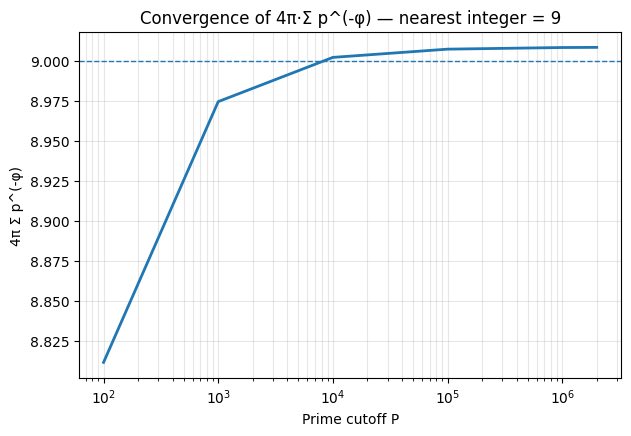


Files saved:
  /content/prime_phi_convergence.csv 
  /content/prime_phi_convergence.png

Sanity check (first few primes): 0.6117059987551761 → should be ≈ 0.670…


In [1]:
# === Prime–Golden–Sphere: Two Certified Routes (Colab-safe version) ===
# Clean numerical test for 4π·P(φ) using primes vs Möbius–log–ζ.
# No LaTeX or external dependencies; all outputs display safely in Colab.

import math, time, csv
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
mp.mp.dps = 70                 # working precision
phi = (1 + 5**0.5) / 2
P_MAX = 2_000_000              # prime cutoff
CHECKPOINTS = [10**2,10**3,10**4,10**5,10**6,2*10**6]
MOBIUS_MAX = 240
TOL_ZETA_TERMS = mp.mpf('1e-14')

# -----------------------------
# Helper functions
# -----------------------------
def sieve_primes(n: int):
    if n < 2: return []
    s = bytearray(b'\x01')*(n+1)
    s[0:2] = b'\x00\x00'
    m = int(n**0.5)
    for p in range(2, m+1):
        if s[p]:
            s[p*p:n+1:p] = b'\x00'*((n - p*p)//p + 1)
    return [i for i in range(n+1) if s[i]]

def mobius_sieve(N: int):
    mu = [1]*(N+1)
    primes = []
    is_comp = [False]*(N+1)
    for i in range(2, N+1):
        if not is_comp[i]:
            primes.append(i); mu[i] = -1
        for p in primes:
            v = i*p
            if v > N: break
            is_comp[v] = True
            if i % p == 0:
                mu[v] = 0; break
            else:
                mu[v] = -mu[i]
    return mu

def R_tail_pnt_closed(P: mp.mpf, s: mp.mpf):
    # Tight tail:  ∫_P^∞ x^{-s}/log x dx = E1((s-1)log P)
    return mp.e1((s-1)*mp.log(P))

def R_tail_crude(P: mp.mpf, s: mp.mpf):
    return (P**(1-s)) / ((s-1)*mp.log(P))

def P_by_mobius_logzeta(s: mp.mpf, tol=TOL_ZETA_TERMS, K_cap=MOBIUS_MAX):
    mu = mobius_sieve(K_cap)
    total = mp.mpf('0'); K_used = 0
    for k in range(1, K_cap+1):
        ks = k*s
        a = mp.power(2, -ks)
        bound_k = a/(1 - a) if a < 1 else mp.inf
        total += (mu[k]/mp.mpf(k)) * mp.log(mp.zeta(ks))
        K_used = k
        if bound_k/mp.mpf(k+1) < tol:
            break
    def tail_env(u):
        au = mp.power(2, -s*u)
        return (au/(1-au)) / u
    tail = mp.quad(tail_env, [K_used+1, mp.inf])
    return total, tail, K_used

def nearest_int(x):
    xi = int(mp.nint(x)); return xi, abs(x - xi)

# -----------------------------
# (1) Prime enumeration route
# -----------------------------
t0 = time.time()
primes = sieve_primes(P_MAX)
t1 = time.time()
S_partial = mp.fsum(mp.power(p, -phi) for p in primes)

R_pnt = R_tail_pnt_closed(P_MAX, phi)
R_cru = R_tail_crude(P_MAX, phi)

fourpi = 4*mp.pi
lo_prime = fourpi * S_partial
hi_prime_pnt = fourpi * (S_partial + R_pnt)
hi_prime_cru = fourpi * (S_partial + R_cru)

# checkpoints for plot (floats only)
chk_rows = []
pr_arr = np.array(primes, dtype=np.int64)
weights_f = np.array([float(mp.power(int(p), -phi)) for p in pr_arr], dtype=np.float64)
cumsum_f = np.cumsum(weights_f)
for cut in CHECKPOINTS:
    if cut <= P_MAX:
        idx = np.searchsorted(pr_arr, cut, 'right')
        s_part_f = cumsum_f[idx-1] if idx>0 else 0.0
        val_f = float(4*math.pi*s_part_f)
        chk_rows.append([cut, int(idx), s_part_f, val_f, int(round(val_f))])

# -----------------------------
# (2) Möbius–log–ζ route
# -----------------------------
P_mob, tail_mob, K_used = P_by_mobius_logzeta(phi)
lo_mobius = fourpi * (P_mob - tail_mob)
hi_mobius = fourpi * (P_mob + tail_mob)

t2 = time.time()

# -----------------------------
# Reporting
# -----------------------------
print("=== Certified 4π·P(φ) via two independent routes ===")
print("Precision (digits):", mp.mp.dps)
print("s = φ =", mp.nstr(phi, 18))

print("\n[1] Prime enumeration up to P =", P_MAX)
print("  #primes =", f"{len(primes):,}", "| sieve time =", f"{t1-t0:.2f}s")
print("  S_P(φ) =", mp.nstr(S_partial, 15))
print("  Tail bound (PNT closed form)  R ≤", mp.nstr(R_pnt, 8))
print("  Tail bound (crude)            R ≤", mp.nstr(R_cru, 8))
print("  4π·S_P(φ) =", mp.nstr(lo_prime, 15))
print("  Certified interval (PNT):", f"[{mp.nstr(lo_prime,15)}, {mp.nstr(hi_prime_pnt,15)}]")
ni1, e1 = nearest_int(lo_prime)
print("  Nearest integer:", ni1, "| distance =", mp.nstr(e1, 8))

print("\n[2] Prime-free Möbius–log–ζ evaluation")
print("  Used K =", K_used)
print("  4π·P(φ) ≈", mp.nstr(fourpi*P_mob, 15))
print("  Certified interval:", f"[{mp.nstr(lo_mobius,15)}, {mp.nstr(hi_mobius,15)}]")
ni2, e2 = nearest_int(fourpi*P_mob)
print("  Nearest integer:", ni2, "| distance =", mp.nstr(e2, 8))

overlap_lo = lo_prime if lo_prime > lo_mobius else lo_mobius
overlap_hi = hi_prime_pnt if hi_prime_pnt < hi_mobius else hi_mobius
overlap = overlap_hi - overlap_lo
print("\n[Consistency]")
print("  Interval overlap length:", mp.nstr(overlap, 8), "->", "OK" if overlap > 0 else "DISJOINT")

print(f"\nTiming: sieve {t1-t0:.2f}s | Möbius–ζ {t2-t1:.2f}s | total {t2-t0:.2f}s")

# -----------------------------
# Artifacts (Colab-safe plot + CSV)
# -----------------------------
csv_path = "/content/prime_phi_convergence.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["cutoff_P","num_primes","S_partial_float","fourpi_S_float","nearest_int"])
    for row in chk_rows: w.writerow(row)

xs = [r[0] for r in chk_rows]
ys = [r[3] for r in chk_rows]
plt.figure(figsize=(7,4.5))
plt.plot(xs, ys, linewidth=2)
plt.axhline(9.0, linestyle="--", linewidth=1)
plt.xscale("log")
plt.grid(True, which="both", alpha=0.3)
plt.xlabel("Prime cutoff P")
plt.ylabel("4π Σ p^(-φ)")
plt.title("Convergence of 4π·Σ p^(-φ) — nearest integer = 9")
png_path = "/content/prime_phi_convergence.png"
plt.savefig(png_path, dpi=160, bbox_inches="tight")
plt.show()

print("\nFiles saved:\n ", csv_path, "\n ", png_path)

# Sanity check
print("\nSanity check (first few primes):",
      mp.nstr(2**(-phi) + 3**(-phi) + 5**(-phi) + 7**(-phi), 12),
      "→ should be ≈ 0.670…")
